In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PyTorch関係
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

ニューラルネットワーク「PyTorch」の、深層距離学習を行うためのライブラリの1つである
「Pytorch Metric Learning」を利用します。

学習後に各ベクトルがどのクラスに一番近いかを調べて評価できるようにするために
faiss-gpuは「FAISS」(Facebook AI Similarity Search)という近似最近傍探索アルゴリズムのためのライブラリです。
ここで、PyTorch Metric Learning の AccuracyCalculatorクラスを使うためにインストールします。


In [3]:
# 深層距離学習用
from pytorch_metric_learning import distances, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [4]:
# 可視化用
#from sklearn.manifold import TSNE # 遅い
from tsnecuda import TSNE # 高速

In [5]:
# 用いるデバイスを変数へ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda:0


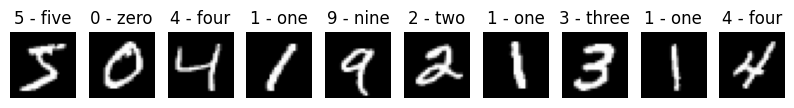

In [6]:
# データセットの準備
transform = transforms.Compose(
  [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256 # バッチサイズ

# データセットの用意（初回はダウンロードされる）
dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, transform=transform)

# PyTorchの DataLoaderへ
train_loader = torch.utils.data.DataLoader(
  dataset1, batch_size=batch_size, shuffle=True
)

# 学習用画像を10枚表示してみる
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
  ax[i].imshow(np.array(dataset1[i][0].permute(1,2,0)), cmap='gray')
  ax[i].set_title(dataset1.classes[dataset1[i][1]])
  ax[i].axis('off')
plt.show()

In [7]:
# 2層の畳み込み層を持つ単純なCNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

In [8]:
def train(model, loss_func, device, train_loader, optimizer, epoch):
  model.train() # 訓練モードへ
  for batch_idx, (data, labels) in enumerate(train_loader):
    data, labels = data.to(device), labels.to(device) # GPUへ
    optimizer.zero_grad() # いったん勾配をリセット
    embeddings = model(data) # 順伝播
    loss = loss_func(embeddings, labels) # 損失計算
    loss.backward() # 誤差逆伝播
    optimizer.step() # パラメータ更新
    if batch_idx % 20 == 0:
      print(f'Epoch {epoch} Iteration {batch_idx}: Loss = {loss}')

In [9]:
# すべてのデータを埋め込む
def get_all_embeddings(dataset, model):
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset, model)

# 評価値計算用（1-NNで分類して精度を評価）
accuracy_calculator = AccuracyCalculator(include=('precision_at_1',), k=1)

# accuracy_calculatorを使ってモデルを評価
def test(train_set, test_set, model, accuracy_calculator):
  # 特徴ベクトル（埋め込み）を計算
  train_embeddings, train_labels = get_all_embeddings(train_set, model)
  test_embeddings, test_labels = get_all_embeddings(test_set, model)
  train_labels = train_labels.squeeze(1)
  test_labels = test_labels.squeeze(1)
  print('Computing accuracy') # 精度を計算
  accuracies = accuracy_calculator.get_accuracy(
    test_embeddings, test_labels, train_embeddings, train_labels, False
  )
  print(f'Test set accuracy (Precision@1) = {accuracies["precision_at_1"]}')
  # 埋め込んだ特徴ベクトルをnumpy ndarrayでreturn
  return train_embeddings.detach().cpu().numpy(), \
    train_labels.detach().cpu().numpy(), \
    test_embeddings.detach().cpu().numpy(), \
    test_labels.detach().cpu().numpy()

In [10]:
num_epochs = 1 # エポック数

model = Net().to(device) # モデル初期化
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 訓練とテスト
for epoch in range(1, num_epochs + 1):
  train(model, losses.NTXentLoss(), device, train_loader, optimizer, epoch)
  train_embeddings, train_labels, test_embeddings, test_labels = test(
    dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 5.250005722045898
Epoch 1 Iteration 20: Loss = 2.044922113418579
Epoch 1 Iteration 40: Loss = 1.4052220582962036
Epoch 1 Iteration 60: Loss = 1.1534744501113892
Epoch 1 Iteration 80: Loss = 1.1363931894302368
Epoch 1 Iteration 100: Loss = 0.9611868858337402
Epoch 1 Iteration 120: Loss = 0.780613362789154
Epoch 1 Iteration 140: Loss = 0.7908827662467957
Epoch 1 Iteration 160: Loss = 0.5198619365692139
Epoch 1 Iteration 180: Loss = 0.4760412573814392
Epoch 1 Iteration 200: Loss = 0.5767324566841125
Epoch 1 Iteration 220: Loss = 0.8062652945518494


100%|██████████| 313/313 [00:03<00:00, 85.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9893000000000001


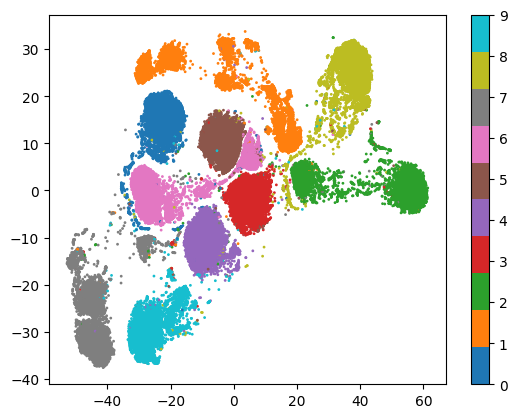

In [11]:
# 2次元で可視化（あくまで参考）
values = TSNE(n_components=2).fit_transform(train_embeddings)
plt.scatter(values[:, 0], values[:, 1], s=1, c=train_labels, cmap='tab10')
plt.colorbar()
plt.show()